In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import pandas as pd

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams["font.size"] = 18
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


In [2]:
df = pd.read_pickle("/home/sam/Code/btc/weathertexasBTC.pickle")
df = df.astype({"weather_type":"int"})

In [3]:
d = df[df.weather_type<2]
df, d.weather_type.values[0]

(            blocktimes_dt  weather_blk  tdeltas  weather_type
 0     2021-03-17 08:27:35          4.0       49             2
 1     2021-03-17 08:28:24          0.0      553             2
 2     2021-03-17 08:37:37          3.0      292             2
 3     2021-03-17 08:42:29          1.0      322             2
 4     2021-03-17 08:47:51          4.0      452             2
 ...                   ...          ...      ...           ...
 48345 2022-02-15 12:49:56          0.0      217             2
 48346 2022-02-15 12:53:33          2.0       23             2
 48347 2022-02-15 12:53:56          2.0     1125             2
 48348 2022-02-15 13:12:41          2.0      654             0
 48349 2022-02-15 13:23:35          2.0      613             0
 
 [48350 rows x 4 columns],
 1)

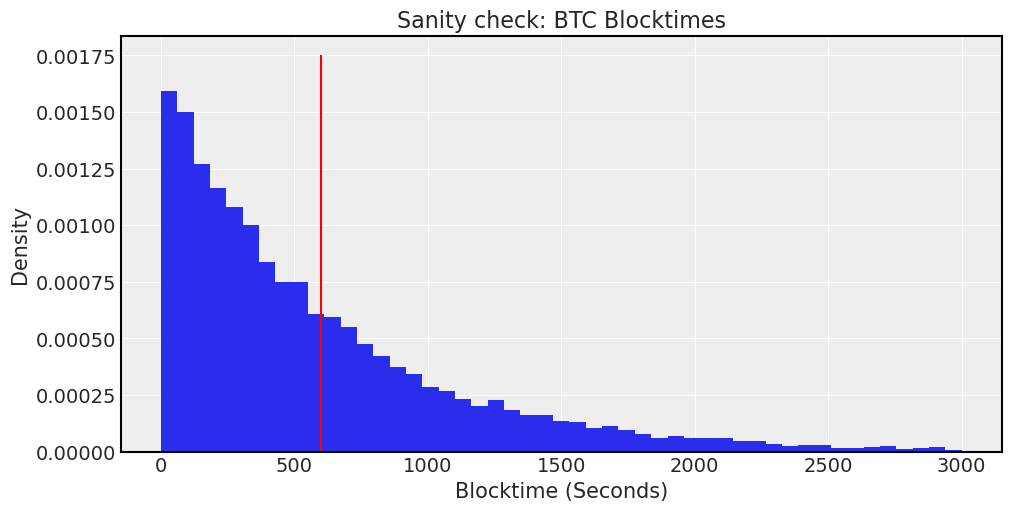

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

bins = np.linspace(0, 3000, 50)
plt.vlines(x=np.mean(d.tdeltas), ymin=0, ymax=0.00175, color="r")
plt.hist(d.tdeltas, bins=bins, density=True)
plt.xlabel("Blocktime (Seconds)")
plt.ylabel("Density");
plt.title("Sanity check: BTC Blocktimes");

In [14]:
# Simple model of the two datasets
# Mean of 600, thus prior is exponential(lambda=1/600)
d0 = df[df.weather_type==0]
d1 = df[df.weather_type==1]
with pm.Model() as model0:
    a = pm.Gamma("a", mu=0.1, sigma=0.5)
    sec = pm.Exponential("sec", a, observed=d0.tdeltas)
    
    trace0 = pm.sample(2000, tune=1000)
    
with pm.Model() as model1:
    a = pm.Gamma("a", mu=0.1, sigma=0.5)
    sec = pm.Exponential("sec", a, observed=d1.tdeltas)
    
    trace1 = pm.sample(2000, tune=1000)

<ipython-input-14-bf4362514cc8>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace0 = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
<ipython-input-14-bf4362514cc8>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace1 = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [ ]:
x = np.linspace(0,10,100)
y = pm.Normal.dist(mu=trace1["a"].mean(), sd=trace1["b"].mean())
s = y.random(size=10000)
print(d0.tdeltas)
plt.hist(s, bins=x, alpha=0.5, label="simulated")
plt.hist(np.log(d0.tdeltas.values+1e-8), bins=x, alpha=0.5, label="data")
plt.legend()
plt.show()

In [150]:
print((d0.tdeltas+1e-8).mean())
print(np.exp(np.log(d0.tdeltas+1e-8)).mean())

590.6308139634926
590.6308139634926


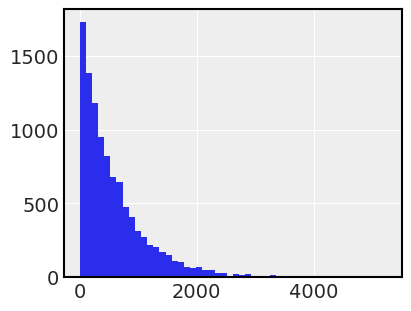

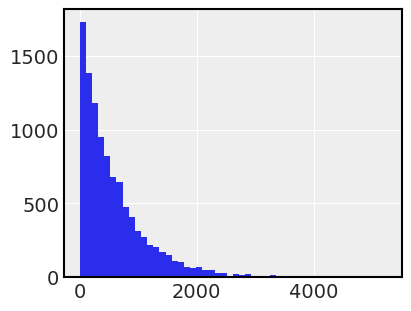

In [149]:
plt.hist((np.exp(np.log(d0.tdeltas+1e-8))), bins=50)
plt.show()
plt.hist(d0.tdeltas+1e-8, bins=50)
plt.show()

/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Average in seconds: 590.7638622523501 611.6366932973934


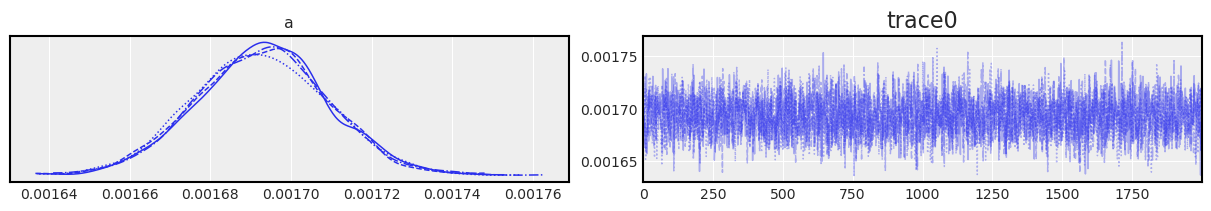

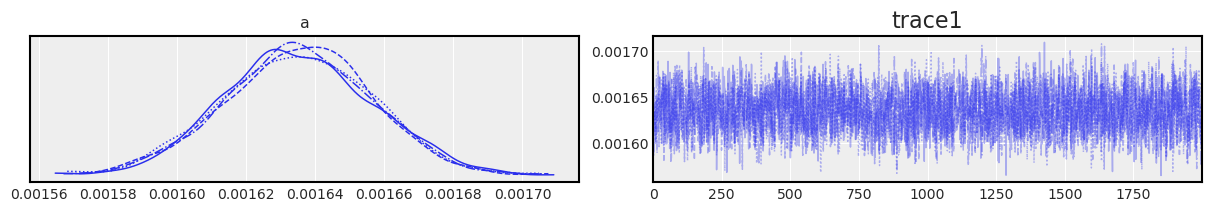

In [17]:
az.plot_trace(trace0)
plt.title("trace0")
az.plot_trace(trace1);
plt.title("trace1")
print("Average in seconds:", 1/trace0["a"].mean(), 1/trace1["a"].mean())

Text(0.5, 0.98, 'Average Bitcoin Blocktime by Texas Weather')

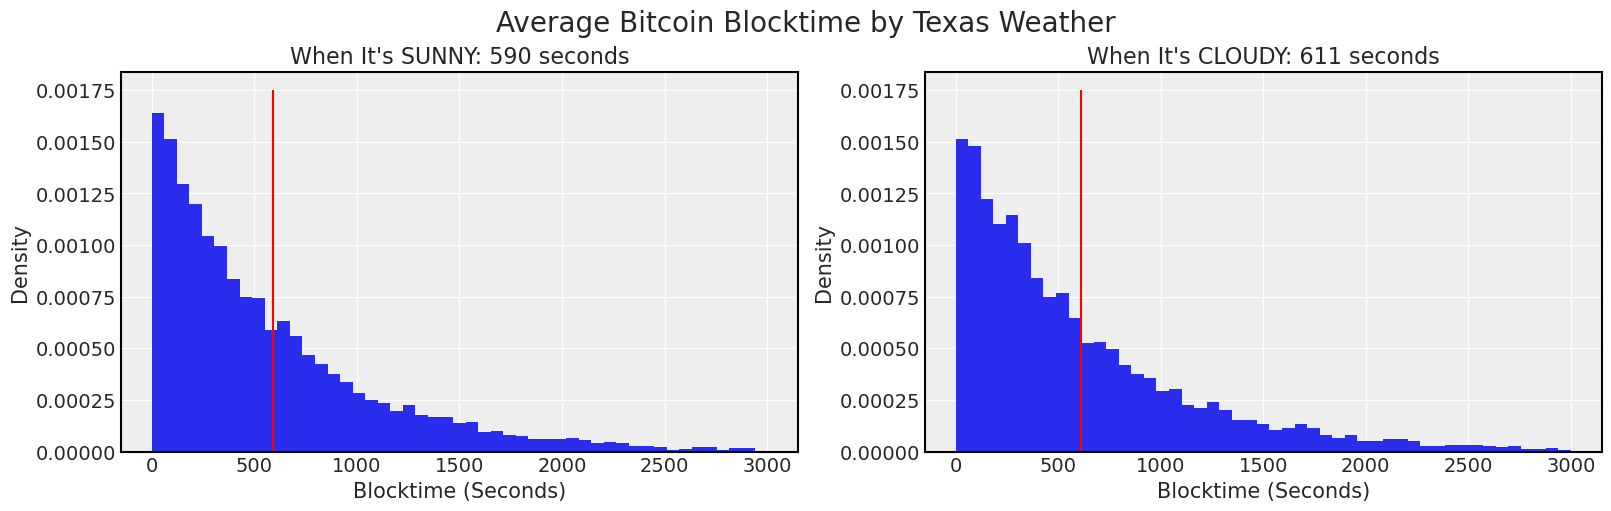

In [18]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
bins = np.linspace(0, 3000, 50)
ax[0].vlines(x=np.mean(d0.tdeltas), ymin=0, ymax=0.00175, color="r")
ax[0].hist(d0.tdeltas, bins=bins, density=True)
ax[0].set_xlabel("Blocktime (Seconds)")
ax[0].set_ylabel("Density");
title= "When It's SUNNY: " + str(int(np.mean(d0.tdeltas))) + " seconds"
ax[0].set_title(title)

ax[1].vlines(x=np.mean(d1.tdeltas), ymin=0, ymax=0.00175, color="r")
ax[1].hist(d1.tdeltas, bins=bins, density=True)
ax[1].set_xlabel("Blocktime (Seconds)")
ax[1].set_ylabel("Density");
title= "When It's CLOUDY: " + str(int(np.mean(d1.tdeltas))) + " seconds"
ax[1].set_title(title)

fig.suptitle("Average Bitcoin Blocktime by Texas Weather", fontsize=20)
#(1/trace0["a"].mean()), (1/trace1["a"].mean())

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


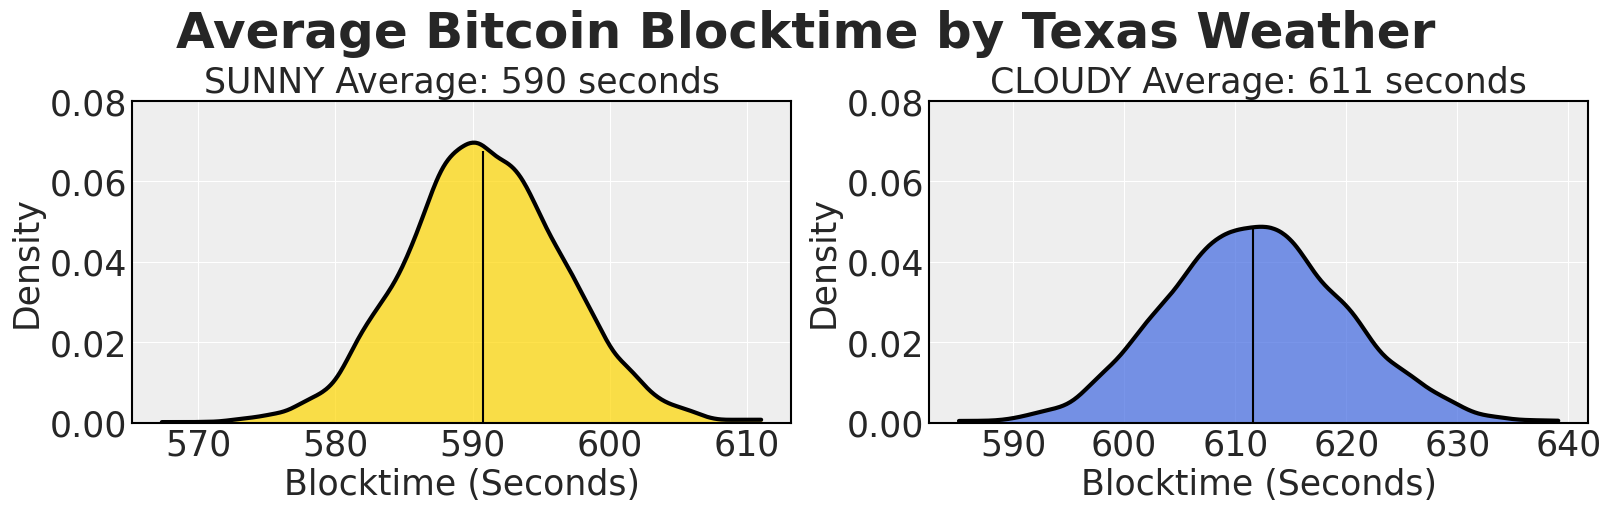

In [19]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 30}

plt.rc('font', **font)
fs = 25

fig, ax = plt.subplots(1,2,figsize=(16,5))

kde = az.plot_kde(1/trace0["a"], ax=ax[0], textsize=fs, plot_kwargs={"color": "k", "linewidth":3})
kde_x, kde_y = kde.lines[0].get_data()
kde.fill_between(kde_x, kde_y, interpolate=True, color="gold", alpha=0.7)
ax[0].set_xlabel("Blocktime (Seconds)", fontsize=fs)
ax[0].set_ylabel("Density", fontsize=fs);
ax[0].set_ylim([0, 0.08])
ax[0].vlines(x=1/trace0["a"].mean(), ymin=0, ymax=0.0675, color="k")
title= "SUNNY Average: " + str(int(np.mean(1/trace0["a"]))) + " seconds"
ax[0].set_title(title, fontsize=fs)

kde = az.plot_kde(1/trace1["a"], ax=ax[1], textsize=fs, plot_kwargs={"color": "k", "linewidth":3})
kde_x, kde_y = kde.lines[0].get_data()
kde.fill_between(kde_x, kde_y, interpolate=True, color="royalblue", alpha=0.7)
ax[1].set_xlabel("Blocktime (Seconds)", fontsize=fs)
ax[1].set_ylabel("Density", fontsize=fs);
ax[1].set_ylim([0, 0.08])
ax[1].vlines(x=1/trace1["a"].mean(), ymin=0, ymax=0.049, color="k")
title= "CLOUDY Average: " + str(int(np.mean(1/trace1["a"]))) + " seconds"
ax[1].set_title(title, fontsize=fs)

fig.suptitle("Average Bitcoin Blocktime by Texas Weather", fontweight="bold")
#plt.savefig("Sidebyside.png", dpi=200)
plt.show()

Probability of sunny blocktimes being shorter than cloudy blocktimes:
0.984875


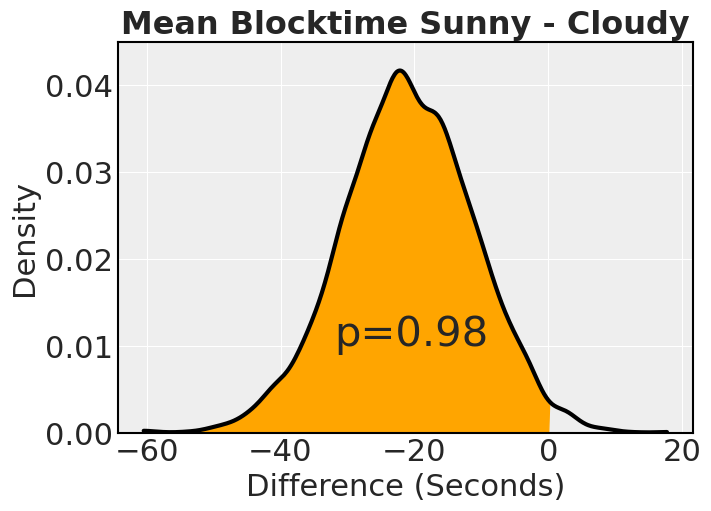

In [32]:
diff = 1/trace0["a"] - 1/trace1["a"]
fs = 22
fig, ax = plt.subplots(figsize=(7,5))

kde = az.plot_kde(diff, textsize=fs, plot_kwargs={"color": "k", "linewidth":3})
kde_x, kde_y = kde.lines[0].get_data()

kde.fill_between(kde_x, kde_y, where=(kde_x<0), interpolate=True, color="orange")
plt.xlabel("Difference (Seconds)", fontsize=fs)
plt.ylabel("Density", fontsize=fs)
plt.ylim([0, 0.045])
plt.text(-32, 0.01, "p=0.98")
plt.title("Mean Blocktime Sunny - Cloudy", fontweight="bold", fontsize=23)

#plt.savefig("Difference.png", dpi=200)
print("Probability of sunny blocktimes being shorter than cloudy blocktimes:")
print(np.sum(diff<0) / len(diff))